In [7]:
import json
import os
import re

# Global dictionary to track function details across multiple log files
call_count = 0
global_function_data = {}
count = 0

def current_project_dir(log_dir):
    """ Getting the base directory path of current project that being processed
    """
    directory_path = os.path.dirname(log_dir)
    
    return directory_path

def get_function_code(method_name, base_dir):
    """Extract the function code from the appropriate Java file."""
    method = method_name.split('(')[0]
    class_name = method.split('.')[-2]
    function_name = method.split('.')[-1]
    java_file_path = os.path.join(base_dir, f"{class_name}.java")

    if not os.path.exists(java_file_path):
        return "No File"

    function_pattern = re.compile(
        rf'\b(?:public|private|protected|static)?\s*[\w<>\[\]]+\s+{function_name}\s*\(.*?\)\s*\{{'
    )
    function_body = []
    inside_function = False
    open_braces = 0

    with open(java_file_path, 'r') as f:
        for line in f:
            if function_pattern.search(line):
                inside_function = True
            if inside_function:
                function_body.append(line)
                open_braces += line.count('{') - line.count('}')
                if open_braces == 0:
                    break

    return "".join(function_body) if function_body else f"No File"

def merge_function_data(function_name, function_code, location, inputs, outputs):
    """Merge inputs and outputs if the function already exists in the global dictionary."""
    # Skip functions that contain 'init()' or 'ESTest'
    if any(keyword in function_name for keyword in ["init()", "ESTest", "<init>()", "error"]) or function_code == "No File":
        return

    # Ignore if both inputs and outputs are empty
    if not inputs or not outputs:
        return


    # Use the function code as a unique key in the global dictionary
    if function_code not in global_function_data:
        global_function_data[function_code] = {
            'name': function_name,
            'code': function_code,
            'location': location,
            'inputs': [],
            'outputs': []
        }

    # Merge inputs and outputs into the existing entry
    global_function_data[function_code]['inputs'].extend(inputs)
    global_function_data[function_code]['outputs'].extend(outputs)

def process_call_traces_with_stack(node, current_project):
    """Recursively process trace data and store function details."""
    if 'children' in node:
        for child in node['children']:
            if child.get('trace_type') == 'call':
                global call_count
                call_count += 1
                function_name = child.get('method', 'Unknown')
                location = child.get('location', 'Unknown')
                function_code = get_function_code(function_name, current_project)

                # Collect inputs
                inputs = []
                for sub_child in child.get('children', []):
                    if sub_child.get('trace_type') == 'entry' and sub_child.get('method') == function_name:
                        inputs = [
                            [{
                                'name': inp.get('name', 'Unknown'),
                                'type': inp.get('type', 'Unknown'),
                                'value': inp.get('value', 'Unknown')
                            }
                            for inp in sub_child.get('children', [])]
                        ]

                # Recursively process nested calls
                process_call_traces_with_stack(child, current_project)

                # Collect outputs
                outputs = []
                for sub_child in child.get('children', []):
                    if sub_child.get('trace_type') == 'exit' and sub_child.get('method') == function_name:
                        outputs = [
                            [{
                                'name': out.get('name', 'Unknown'),
                                'type': out.get('type', 'Unknown'),
                                'value': out.get('value', 'Unknown')
                            }
                            for out in sub_child.get('children', [])]
                        ]

                # Merge data into the global dictionary
                merge_function_data(function_name, function_code, location, inputs, outputs)

def save_to_jsonl(output_file="function_details_java.jsonl"):
    """Save the global function data to a JSONL file."""
    with open(output_file, 'w') as f:
        for entry in global_function_data.values():
            f.write(json.dumps(entry) + '\n')


def process_log_file(log_path):
    """Process the log file and handle errors."""
    global count
    current_project = current_project_dir(log_path)

    try:
        with open(log_path, 'r', encoding='utf-8') as log_file:
            log_data = json.load(log_file)
            process_call_traces_with_stack(log_data, current_project)
    except (UnicodeDecodeError, json.JSONDecodeError) as e:
        print(f"Skipping invalid or corrupt log file: {log_path} - {e}")
        count += 1

# Specify the base path and iterate over all log files
# base_project_path = '/home/XXX/Tracing/Annotation/traces_new/2_a4j'


def collect_project_dir():
    """Getting Project paths for all 46 projects
    """
    base_dir = '//home/XXX/Tracing/Annotation/Java Post Processed Files/traces_new'
    
    project_list = []
    
    for project in os.listdir(base_dir):
        project_list.append(os.path.join(base_dir, project))
        
    return project_list



project_list = collect_project_dir()

for base_project_path in project_list:
    for jclass in os.listdir(base_project_path):
        jclass_path = os.path.join(base_project_path, jclass)

        if os.path.isdir(jclass_path):
            for file in os.listdir(jclass_path):
                if file.endswith('.json'):
                    process_log_file(os.path.join(jclass_path, file))

# Save the results to a JSONL file
save_to_jsonl()
print(count)

Skipping invalid or corrupt log file: //home/XXX/Tracing/Annotation/Java Post Processed Files/traces_new/40_glengineer/trace_glengineer.agents.SequentialGroupAgent/log_1.json - 'utf-8' codec can't decode byte 0xc0 in position 214: invalid start byte
Skipping invalid or corrupt log file: //home/XXX/Tracing/Annotation/Java Post Processed Files/traces_new/40_glengineer/trace_glengineer.agents.SequentialGroupAgent/log_2.json - 'utf-8' codec can't decode byte 0xc0 in position 214: invalid start byte
Skipping invalid or corrupt log file: //home/XXX/Tracing/Annotation/Java Post Processed Files/traces_new/40_glengineer/trace_glengineer.agents.SequentialGroupAgent/log_0.json - 'utf-8' codec can't decode byte 0xc0 in position 214: invalid start byte
Skipping invalid or corrupt log file: //home/XXX/Tracing/Annotation/Java Post Processed Files/traces_new/40_glengineer/trace_glengineer.agents.settings.GapSettings/log_1.json - 'utf-8' codec can't decode byte 0xca in position 47: invalid continuation

In [8]:
print(call_count)

291762


In [34]:
import json
import re
import pandas as pd

primitive_types = ['int', 'float', 'double', 'long', 'char', 'boolean', 'byte', 'short']

# Regex pattern to identify decision points contributing to cyclomatic complexity
decision_pattern = re.compile(r'\b(if|else if|for|while|do|switch|case|catch)\b')

def cyclomatic_complexity(code):
    """
    Calculate the cyclomatic complexity of a given Java code snippet.
    """
    matches = decision_pattern.findall(code)
    return len(matches) + 1 

def input_output_type_profiling(input_parameters, output_parameters):
    count_primitive_inputs = 0
    count_java_packages_inputs = 0
    count_complex_inputs = 0
    count_primitive_outputs = 0
    count_java_packages_outputs = 0
    count_complex_outputs = 0

    for parameters in input_parameters:
        if parameters['type'] in primitive_types:
            count_primitive_inputs += 1
        elif parameters['type'].startswith("java") or parameters['type'].startswith("javax"):
            count_java_packages_inputs += 1
        else:
            count_complex_inputs += 1

    for parameters in output_parameters:
        if parameters['type'] in primitive_types:
            count_primitive_outputs += 1
        elif parameters['type'].startswith("java") or parameters['type'].startswith("javax"):
            count_java_packages_outputs += 1
        else:
            count_complex_outputs += 1

    return (count_primitive_inputs, count_java_packages_inputs, count_complex_inputs, 
            count_primitive_outputs, count_java_packages_outputs, count_complex_outputs)


function_profiling = []


with open('function_details_java.jsonl', 'r') as f:
    for line in f:
        entry = json.loads(line)

        try:
            if entry['inputs'] and entry['outputs']:
                first_input = entry['inputs'][0]
                first_output = entry['outputs'][0]

                (count_primitive_inputs, count_java_packages_inputs, count_complex_inputs, 
                 count_primitive_outputs, count_java_packages_outputs, count_complex_outputs) = (
                    input_output_type_profiling(first_input, first_output)
                )

                cc = cyclomatic_complexity(entry['code'])

                function_profiling.append({
                    'name': entry['name'],
                    'code': entry['code'],
                    'primitive_inputs': count_primitive_inputs,
                    'java_packages_input': count_java_packages_inputs,
                    'complex_inputs': count_complex_inputs,
                    'primitive_output': count_primitive_outputs,
                    'java_packages_output': count_java_packages_outputs,
                    'complex_outputs': count_complex_outputs,
                    'line_count': len(entry['code'].splitlines()),
                    'cyclomatic_complexity': cc
                })

        except (IndexError, KeyError) as e:
            print(f"Error processing entry {entry.get('name', 'unknown')}: {e}")


df = pd.DataFrame(function_profiling)
df.to_excel('java_function_profiling_results.xlsx', index=False)

print("Function profiling completed and saved to 'function_profiling_results.xlsx'.")


Function profiling completed and saved to 'function_profiling_results.xlsx'.


In [2]:
import pandas as pd

df = pd.read_excel('java_function_profiling_results.xlsx')


quartiles = df['line_count'].quantile([0.25, 0.50, 0.75])
cyclo_quartiles = df['cyclomatic_complexity'].quantile([0.25, 0.50, 0.75])


print("Quartiles for 'line_count':")
print(quartiles)
print(max(df['line_count']))
print(cyclo_quartiles)
print(max(df['cyclomatic_complexity']))

count_greater_than_20 = df[df['line_count'] > 20].shape[0]


print(f"Number of rows with 'line_count' greater than 20: {count_greater_than_20}")


Quartiles for 'line_count':
0.25    3.0
0.50    3.0
0.75    6.0
Name: line_count, dtype: float64
108
0.25    1.0
0.50    1.0
0.75    1.5
Name: cyclomatic_complexity, dtype: float64
52
Number of rows with 'line_count' greater than 20: 62


In [3]:

summary = pd.DataFrame({
    'Total Entries': [len(df)],
    'Total Primitive Inputs': [df['primitive_inputs'].sum()],
    'Total Java Package Inputs': [df['java_packages_input'].sum()],
    'Total Complex Inputs': [df['complex_inputs'].sum()],
    'Total Primitive Outputs': [df['primitive_output'].sum()],
    'Total Java Package Outputs': [df['java_packages_output'].sum()],
    'Total Complex Outputs': [df['complex_outputs'].sum()],
    'Average Line Count': [df['line_count'].mean()],
    'Average Cyclomatic Complexity': [df['cyclomatic_complexity'].mean()]
})


print(summary)

   Total Entries  Total Primitive Inputs  Total Java Package Inputs  \
0            875                    5417                       5142   

   Total Complex Inputs  Total Primitive Outputs  Total Java Package Outputs  \
0                  1306                     5511                        5245   

   Total Complex Outputs  Average Line Count  Average Cyclomatic Complexity  
0                   1357            7.174857                       1.893714  


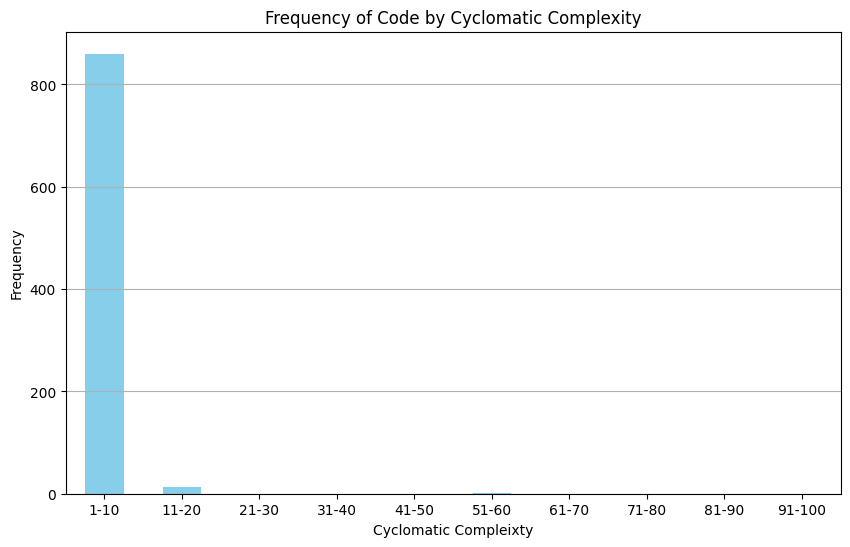

In [4]:

import matplotlib.pyplot as plt




bins = list(range(1, 111, 10))  
labels = [f'{i}-{i+9}' for i in bins[:-1]] 


df['line_count_range'] = pd.cut(df['cyclomatic_complexity'], bins=bins, labels=labels, right=False)


frequency = df['line_count_range'].value_counts().reindex(labels, fill_value=0)

# Plot the bar chart
plt.figure(figsize=(10, 6))
frequency.plot(kind='bar', color='skyblue')
plt.title('Frequency of Code by Cyclomatic Complexity')
plt.xlabel('Cyclomatic Compleixty')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()


# Java Input/Output Profiling

In [2]:
import json
import re

decision_pattern = re.compile(r'\b(if|else if|for|while|do|switch|case|catch)\b')

def cyclomatic_complexity(code):
    """
    Calculate the cyclomatic complexity of a given Java code snippet.
    """
    matches = decision_pattern.findall(code)
    return len(matches) + 1 

primitive_types = {'int', 'boolean', 'double', 'float', 'char', 'byte', 'short', 'long'}
primitive_wrapper_classes = {'Integer', 'Boolean', 'Double', 'Float', 'Character', 'Byte', 'Short', 'Long', 'BigInteger', 'BigDecimal'}
string_array_packages = {'String', 'String[]', 'List', 'ArrayList', 'Map', 'HashMap', 'Set', 'HashSet'}

allowed_types = primitive_types | primitive_wrapper_classes | string_array_packages

all_primitive = 0
all_primitive_wrapper = 0
all_string_array = 0
count = 0
allowed_functions_count = 0  # To count functions with at least one allowed input and output
complexity = []
length = []

idx = 0 
with open('function_details_java.jsonl') as f:
    for line in f:
        func = json.loads(line)
        code = func.get('code', '')

        signature_match = re.search(r'(?:public|protected|private)?\s*(?:static\s*)?([\w<>\[\].]+)\s+\w+\s*\(([^)]*)\)', code)
        if signature_match:
            return_type, parameters = signature_match.groups()

            parameter_types = [param.split()[0] for param in parameters.split(",") if param]

            has_allowed_input = any(param in allowed_types for param in parameter_types)
            has_allowed_output = return_type in allowed_types
            
            # Count if there's at least one allowed input and output
            if has_allowed_input and has_allowed_output:
                
                print(f"idx:{idx}, Code:{code}")
                print(f"Input:{func.get('inputs')[0]}")
                print(f"Output:{func.get('outputs')[0]}")
                print("\n")
                
                idx += 1
            #     allowed_functions_count += 1
                
            #     complexity.append(cyclomatic_complexity(code))
            #     length.append(len(code.splitlines()))
            #     print(f"Cyclomatic Complexity:{cyclomatic_complexity(code)} and Line:{len(code.splitlines())}")
                

            # if return_type in primitive_types and all(param in primitive_types for param in parameter_types) and len(parameter_types) > 0:
            #     all_primitive += 1
            # elif return_type in primitive_wrapper_classes and all(param in primitive_wrapper_classes for param in parameter_types) and len(parameter_types) > 0:
            #     all_primitive_wrapper += 1
            # elif return_type in string_array_packages and all(param in string_array_packages for param in parameter_types) and len(parameter_types) > 0:
            #     all_string_array += 1
            # if return_type in allowed_types and all(param in allowed_types for param in parameter_types) and len(parameter_types) > 0:
            #     count += 1

# # Print results
# print(all_primitive)
# print(all_primitive_wrapper)
# print(all_string_array)
# print(count)
# print(allowed_functions_count)  # Print the count of functions with at least one allowed input and output


idx:0, Code:    public String addBinary(String num1, String num2) {
        boolean carry = false;
        int size1 = num1.length() - 1;
        int size2 = num2.length() - 1;
        String sum = "";
        
        if (size2 > size1) {
            String s = num1;
            num1 = num2;
            num2 = s;
            int n = size1;
            size1 = size2;
            size2 = n;
        }
        
        for (; size2 >= 0 ; size1--, size2--) {
            if (num1.charAt(size1) == '0' && num2.charAt(size2) == '0') {
                if (!carry)
                    sum = "0" + sum;
                else
                    sum = "1" + sum;
                carry = false;
            } else if (num1.charAt(size1) == '1' && num2.charAt(size2) == '0') {
                if (!carry)
                    sum = "1" + sum;
                else {
                    sum = "0" + sum;
                    carry = true;
                }
            } else if (num1.charAt(size1) == '0' && nu

In [3]:
import numpy as np

if complexity:
    q1 = np.percentile(complexity, 25)
    q2 = np.percentile(complexity, 50)  # Median
    q3 = np.percentile(complexity, 75)

    # Count elements in each quartile
    q1_count = sum(1 for x in complexity if x <= q1)
    q2_count = sum(1 for x in complexity if q1 < x <= q2)
    q3_count = sum(1 for x in complexity if q2 < x <= q3)
    q4_count = sum(1 for x in complexity if x > q3)

    # Print results
    print(f"Q1: {q1}, Count: {q1_count}")
    print(f"Q2: {q2}, Count: {q2_count}")
    print(f"Q3: {q3}, Count: {q3_count}")
    print(f"Q4: > {q3}, Count: {q4_count}")
    
if length:
    q1 = np.percentile(length, 25)
    q2 = np.percentile(length, 50)  # Median
    q3 = np.percentile(length, 75)

    # Count elements in each quartile
    q1_count = sum(1 for x in length if x <= q1)
    q2_count = sum(1 for x in length if q1 < x <= q2)
    q3_count = sum(1 for x in length if q2 < x <= q3)
    q4_count = sum(1 for x in length if x > q3)

    # Print results
    print(f"Q1: {q1}, Count: {q1_count}")
    print(f"Q2: {q2}, Count: {q2_count}")
    print(f"Q3: {q3}, Count: {q3_count}")
    print(f"Q4: > {q3}, Count: {q4_count}")

Q1: 1.0, Count: 52
Q2: 1.0, Count: 0
Q3: 3.0, Count: 10
Q4: > 3.0, Count: 15
Q1: 3.0, Count: 33
Q2: 6.0, Count: 6
Q3: 21.0, Count: 20
Q4: > 21.0, Count: 18


#Preparing Dataset

In [12]:
import json
import re

decision_pattern = re.compile(r'\b(if|else if|for|while|do|switch|case|catch)\b')

def cyclomatic_complexity(code):
    """
    Calculate the cyclomatic complexity of a given Java code snippet.
    """
    matches = decision_pattern.findall(code)
    return len(matches) + 1 

primitive_types = {'int', 'boolean', 'double', 'float', 'char', 'byte', 'short', 'long'}
primitive_wrapper_classes = {'Integer', 'Boolean', 'Double', 'Float', 'Character', 'Byte', 'Short', 'Long', 'BigInteger', 'BigDecimal'}
string_array_packages = {'String', 'String[]', 'List', 'ArrayList', 'Map', 'HashMap', 'Set', 'HashSet'}

allowed_types = primitive_types | primitive_wrapper_classes | string_array_packages

all_primitive = 0
all_primitive_wrapper = 0
all_string_array = 0
count = 0
allowed_functions_count = 0  # To count functions with at least one allowed input and output
complexity = []
length = []

java_dataset = []

idx = 0
with open('function_details_java.jsonl') as f:
    for line in f:
        func = json.loads(line)
        code = func.get('code', '')
        


        signature_match = re.search(r'(?:public|protected|private)?\s*(?:static\s*)?([\w<>\[\].]+)\s+\w+\s*\(([^)]*)\)', code)
        if signature_match:
            return_type, parameters = signature_match.groups()

            parameter_types = [param.split()[0] for param in parameters.split(",") if param]

            has_allowed_input = any(param in allowed_types for param in parameter_types)
            has_allowed_output = return_type in allowed_types
            
            # Count if there's at least one allowed input and output
            if has_allowed_input and has_allowed_output:  
                java_dataset.append(
                    {
                        "idx": idx,
                        "code": code,
                        "basic_input": func.get('inputs')[0],
                        "output": func.get('outputs')[0],
                        "cyclomatic_complexity": cyclomatic_complexity(code),
                        "code_length": len(code.splitlines()),
                        
                    }
                )
                idx += 1
                # if len(func.get('inputs')) > 1:
                #     print(f"Input: {func.get('inputs')[1]}")
                #     print(f"Output:{func.get('outputs')[1]}")
                # else:
                #     print(f"Input: {func.get('inputs')[0]}")
                #     print(f"Output:{func.get('outputs')[0]}")
                
                # print(f"Input: {func.get('inputs')[0]}")
                # print(f"Output:{func.get('outputs')[0]}")
                # print("\n\n")


with open('java_dataset.jsonl', 'w') as f:
    for entry in java_dataset:
        json.dump(entry, f)
        f.write('\n')  # Write a newline after each JSON object


print("Java dataset saved to 'java_dataset.jsonl' with improved readability.")


Java dataset saved to 'java_dataset.jsonl' with improved readability.


In [106]:
import json
import re

# Initialize a list to hold the generated prompts
prompts = []

with open('evaluation_dataset_java_new.jsonl') as f:
    for line_num, line in enumerate(f, 1):  
        try:
            func = json.loads(line)
            
            code = func.get('code')
            input_data = func.get('basic_input', [])
            output = func.get('output', [{}])[0].get('value', 'UNKNOWN')  # Get expected output

            # Extract the function signature
            signature_match = re.search(r'(?:public|protected|private)?\s*(?:static\s*)?([\w<>\[\].]+)\s+(\w+)\s*\(([^)]*)\)', code)
            if signature_match:
                return_type, function_name, parameters = signature_match.groups()

                # Split the parameters string by commas and strip extra spaces
                param_names = [param.strip().split()[-1] for param in parameters.split(',')]

                # Map input_data to the parameters based on the order of param_names
                input_values = {}
                for param in input_data:
                    param_name = param.get('name')
                    value = param.get('value')
                    param_type = param.get('type')
    
                    if param_name:  # If the parameter has a name, we associate it with the value
                        if param_type == "java.lang.String" or param_type == "string":
                            if value == "\"\"":
                                formatted_value = "\"\""
                            else:
                                formatted_value = f'"{value}"' if value is not None else ""
                        else:
                            formatted_value = str(value) if value is not None else '0' 
                        
                        input_values[param_name] = formatted_value

                # Now reorder the input_values based on the function's parameter names
                ordered_input_values = [input_values.get(param_name, '??') for param_name in param_names]
                
                # Create the param_list string
                param_list = ", ".join(ordered_input_values)  

                # Create the prompt in the format "assert function_name(param_list) == output"
                prompt = f"assert {function_name}({param_list}) == {output}"
                prompts.append(prompt)
        
        except json.JSONDecodeError as e:
            print(f"JSONDecodeError at Line {line_num}: {line.strip()[:100]}...") 
            print(f"Error: {e}")

# Output the generated prompts
for prompt in prompts:
    print(prompt)



assert addBinary("1", "0") == "1"
assert getNetmask("") == ""
assert convert("1") == ""
assert modfloor(1065.3917804433, 1065.3917804433) == 1065.3917804433
assert modceil(0.0, 100.0) == 0.0
assert Normalize(-882) == 0
assert GetTableName("Start \tCreation Time \tIndex \tCreate Time String\tQuery") == "\tCreation"
assert IntMaxString(2147483647) == 2147483647
assert NormalizeString("") == ""
assert StringCompare("", "0.0") == -1
assert StringIsEmpty("") == True
assert StringCompareIgnCase("-2990", "com.ib.client.Util") == -1
assert DoubleMaxString(0.0) == 0.0
assert IsEmpty("1") == False
assert accountDownloadEnd() == None
assert getField(1069) == unknown
assert tickGeneric(597, 1069, -1189.0) == id=597  int=-1189.0
assert contractDetailsEnd(13) == reqId = 13 =============== end ===============
assert fundamentalData(0, "h%(4&9G"Gv|cT") == id  = 0 len = 12\nh%(4&9G"Gv|cT
assert tickPrice(-2099, -2099, -2099.0, -2099) == id=-2099  unknown=-2099.0 canAutoExecute
assert nextValidId(10) ==

In [108]:
import json

def categorize_complexity(complexity):
    if complexity == 1:
        return "Easy"
    elif 2 <= complexity <= 3:
        return "Medium"
    elif complexity > 3:
        return "Hard"
    return None  # In case the complexity doesn't match any criteria

def add_category_to_dataset(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            data_entry = json.loads(line)
            # Add the new category based on cyclomatic complexity
            complexity = data_entry.get("cyclomatic_complexity")
            data_entry["category"] = categorize_complexity(complexity)
            # Write the updated entry to the output file
            outfile.write(json.dumps(data_entry) + '\n')

# Define your input and output file paths
input_file_path = 'evaluation_dataset_java_new.jsonl'
output_file_path = 'evaluation_dataset_java_updated.jsonl'

# Add categories to the dataset
add_category_to_dataset(input_file_path, output_file_path)

print("Categories added to the dataset.")


Categories added to the dataset.


In [6]:
import json

file_path = "/home/XXX/Traces/prompting/data/evaluation_dataset_c.jsonl"

with open(file_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        
        print("\n" + "=" * 80)
        print("Function:")
        formatted_code = data["code"].replace("\\n", "\n")
        print(formatted_code)
        
        print("\nInput:")
        if isinstance(data["basic_input"], list):
            for input_item in data["basic_input"]:
                print(f"  {input_item['name']}: {repr(input_item['value'])}")
        else: 
            for key, val in data["basic_input"].items():
                print(f"  {key}: {repr(val['value'])}")
        
        print("\nOutput:")
        if isinstance(data["output"], list):
            for output_item in data["output"]:
                print(f"  {output_item['name']}: {output_item['value']} ({output_item['type']})")
        else: 
            print(f"  return value: {data['output']['value']} ({data['output']['type']})")
        
        print("=" * 80 + "\n")


Function:
int
http_parse_header_line(struct http_parser *prsr, const char **bufp,
		       const char *end_buf, int max_hname_len)
{
	char c;
	unsigned char ch;
	const char *p = *bufp;
	const char *header_name_start = p;
	prsr->hdr_name_idx = 0;

	enum {
		sw_start = 0,
		skip_status_line,
		skipped_status_line_almost_done,
		sw_name,
		sw_space_before_value,
		sw_value,
		sw_space_after_value,
		sw_almost_done,
		sw_header_almost_done
	} state = sw_start;

	
	static char lowcase[] =
			"\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0"
			"\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0-\0\0" "0123456789"
			"\0\0\0\0\0\0\0abcdefghijklmnopqrstuvwxyz\0\0\0\0_\0"
			"abcdefghijklmnopqrstuvwxyz\0\0\0\0\0\0\0\0\0\0\0\0\0\0"
			"\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0"
			"\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0"
			"\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0"
			"\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0"
			"\0\0\0\0\0\0\0\0\0\0";

	for 

In [ ]:
import json

file_path = "/home/XXX/Tracing/Annotation/Java Post Processed Files/evaluation_dataset_java_updated.jsonl"

with open(file_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        
        print("\n" + "=" * 80)
        print("Function:")
        formatted_code = data["code"].replace("\\n", "\n")
        print(formatted_code)
        
        print("\nInput:")
        for input_item in data["basic_input"]:
            print(f"  {input_item['name']}: {repr(input_item['value'])}")
        
        print("\nOutput:")
        for output_item in data["output"]:
            print(f"  {output_item['name']}: {output_item['value']} ({output_item['type']})")
        
        print("=" * 80 + "\n")


Function:
    public String addBinary(String num1, String num2) {
        boolean carry = false;
        int size1 = num1.length() - 1;
        int size2 = num2.length() - 1;
        String sum = \"\";
        
        if (size2 > size1) {
            String s = num1;
            num1 = num2;
            num2 = s;
            int n = size1;
            size1 = size2;
            size2 = n;
        }
        
        for (; size2 >= 0 ; size1--, size2--) {
            if (num1.charAt(size1) == '0' && num2.charAt(size2) == '0') {
                if (!carry)
                    sum = \"0\" + sum;
                else
                    sum = \"1\" + sum;
                carry = false;
            } else if (num1.charAt(size1) == '1' && num2.charAt(size2) == '0') {
                if (!carry)
                    sum = \"1\" + sum;
                else {
                    sum = \"0\" + sum;
                    carry = true;
                }
            } else if (num1.charAt(size1) == 

#